In [1]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from qiskit.circuit.library import PauliFeatureMap
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit.primitives import Sampler
import time
from qiskit_machine_learning.algorithms.classifiers import QSVC
import numpy as np


In [2]:
iris_data = load_iris()

X = iris_data.data
y = iris_data.target

X = MinMaxScaler().fit_transform(X)

In [3]:
X.shape

(150, 4)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [5]:
svc = SVC()
svc.fit(X_train, y_train) 
svc_pred = svc.predict(X_test)

In [6]:
svc_train_score = svc.score(X_train, y_train)
svc_test_score = svc.score(X_test, y_test)

print(f"SVC on the training dataset: {svc_train_score:.2f}")
print(f"SVC on the test dataset:     {svc_test_score:.2f}")

SVC on the training dataset: 0.99
SVC on the test dataset:     0.97


In [7]:
svc_accuracy = accuracy_score(y_test, svc_pred)
svc_precision = precision_score(y_test, svc_pred, average='macro')
svc_recall = recall_score(y_test, svc_pred, average='macro')
svc_f1 = f1_score(y_test, svc_pred, average='macro')

In [8]:
# Print the metrics for both models
print(f"SVC Accuracy: {svc_accuracy:.2f}")
print(f"SVC Precision: {svc_precision:.2f}")
print(f"SVC Recall: {svc_recall:.2f}")
print(f"SVC F1 Score: {svc_f1:.2f}")

SVC Accuracy: 0.97
SVC Precision: 0.95
SVC Recall: 0.97
SVC F1 Score: 0.96


### QSVC

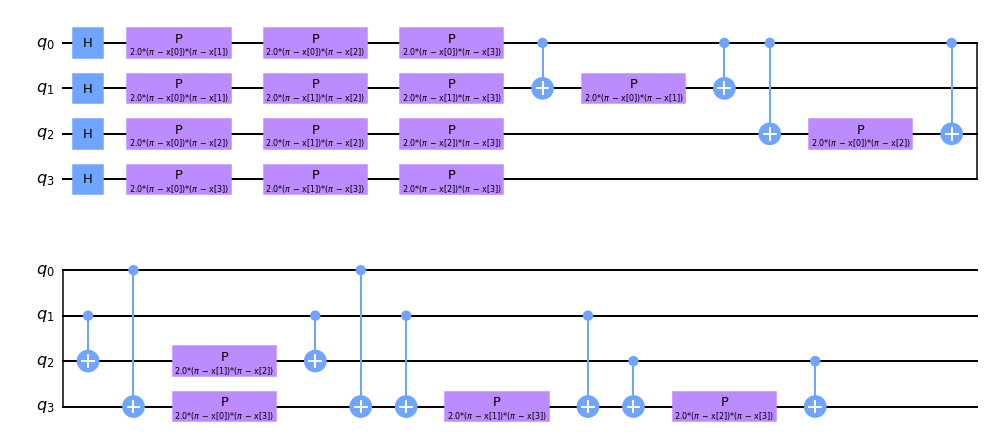

In [9]:
num_features = X.shape[1]
feature_map = PauliFeatureMap(feature_dimension=num_features, 
                              paulis = ['ZI','IZ','ZZ'],
                              reps=1, 
                              entanglement='full'
                              )
# feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [10]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [11]:
qsvc = QSVC(quantum_kernel=kernel)

In [12]:
start = time.time()
qsvc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 275 seconds


In [13]:
qsvc_train_score = qsvc.score(X_train, y_train)
qsvc_test_score = qsvc.score(X_test, y_test)

print(f"Quantum SVC on the training dataset: {qsvc_train_score:.2f}")
print(f"Quantum SVC on the test dataset:     {qsvc_test_score:.2f}")

Quantum SVC on the training dataset: 0.91
Quantum SVC on the test dataset:     0.57


In [14]:
qsvc_pred = qsvc.predict(X_test)

In [15]:
qsvc_accuracy = accuracy_score(y_test, qsvc_pred)
qsvc_precision = precision_score(y_test, qsvc_pred, average='macro')
qsvc_recall = recall_score(y_test, qsvc_pred, average='macro')
qsvc_f1 = f1_score(y_test, qsvc_pred, average='macro')

In [16]:
# Print the metrics for both models
print(f"QSVC Accuracy: {qsvc_accuracy:.2f}")
print(f"QSVC Precision: {qsvc_precision:.2f}")
print(f"QSVC Recall: {qsvc_recall:.2f}")
print(f"QSVC F1 Score: {qsvc_f1:.2f}")

QSVC Accuracy: 0.57
QSVC Precision: 0.59
QSVC Recall: 0.55
QSVC F1 Score: 0.55


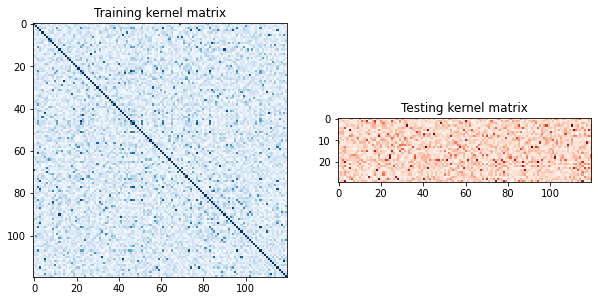

In [17]:
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()